In [336]:
import io
import os
import re
import shutil
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model

tf.config.run_functions_eagerly(True)

In [337]:
train_df = pd.read_csv('train_base.csv')
valid_df = pd.read_csv('valid_base.csv')
test_df = pd.read_csv('test_base.csv')

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707210 entries, 0 to 707209
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   left_synset_id   707210 non-null  int64 
 1   relation         707210 non-null  object
 2   right_synset_id  707210 non-null  int64 
 3   is_valid         707210 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 21.6+ MB


In [338]:
X_train, y_train = train_df.drop(columns=['is_valid']), train_df.is_valid.astype(np.float32)
X_valid, y_valid = valid_df.drop(columns=['is_valid']), valid_df.is_valid.astype(np.float32)
X_test, y_test = test_df.drop(columns=['is_valid']), test_df.is_valid.astype(np.float32)

In [339]:
X_train

,left_synset_id,relation,right_synset_id
0,3341707,_instance_hypernym,1143279
1,2609169,_member_of_domain_usage,5330244
2,12062227,_member_holonym,14742
3,12474620,_hyponym,9003284
4,466053,_member_holonym,10200781
...,...,...,...
707205,12799776,_member_of_domain_region,4505036
707206,1692713,_member_meronym,1693020
707207,53889,_part_of,2652158
707208,9309820,_synset_domain_region_of,3594277


In [340]:
y_train

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
707205    0.0
707206    1.0
707207    0.0
707208    0.0
707209    1.0
Name: is_valid, Length: 707210, dtype: float32

In [341]:
# left_synset_id	relation	right_synset_id
EMBEDDING_DIM = 8

left_synset_input = keras.Input(shape=(1,), name='left_synset_id', dtype='int32')
relation_input = keras.Input(shape=(1,), name='relation', dtype='string')
right_synset_input = keras.Input(shape=(1,), name='right_synset_id', dtype='int32')

relation_one_hot = layers.StringLookup(
    vocabulary=list(set(train_df.relation)),
    output_mode='one_hot',
)(relation_input)

synset_lookup = layers.IntegerLookup(
    vocabulary=list(set(train_df.left_synset_id) | set(train_df.right_synset_id)),
)
synset_embedding = layers.Embedding(
    input_dim = synset_lookup.vocabulary_size(),
    output_dim = EMBEDDING_DIM,
)
flatten = layers.Flatten()

left_synset_embedding = flatten(synset_embedding(synset_lookup(left_synset_input)))
right_synset_embedding = flatten(synset_embedding(synset_lookup(right_synset_input)))

In [342]:
inputs = [left_synset_input, relation_input, right_synset_input]

x = layers.Concatenate()([left_synset_embedding, relation_one_hot, right_synset_embedding])
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)

In [343]:
model = Model(
    inputs=inputs,
    outputs=output,
)

In [344]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [345]:
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_synset_id (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 right_synset_id (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 integer_lookup_22 (IntegerLook  (None, 1)           0           ['left_synset_id[0][0]',         
 up)                                                              'right_synset_id[0][0]']        
                                                                                                  
 embedding_23 (Embedding)       (None, 1, 8)         327552      ['integer_lookup_22[0][0]'

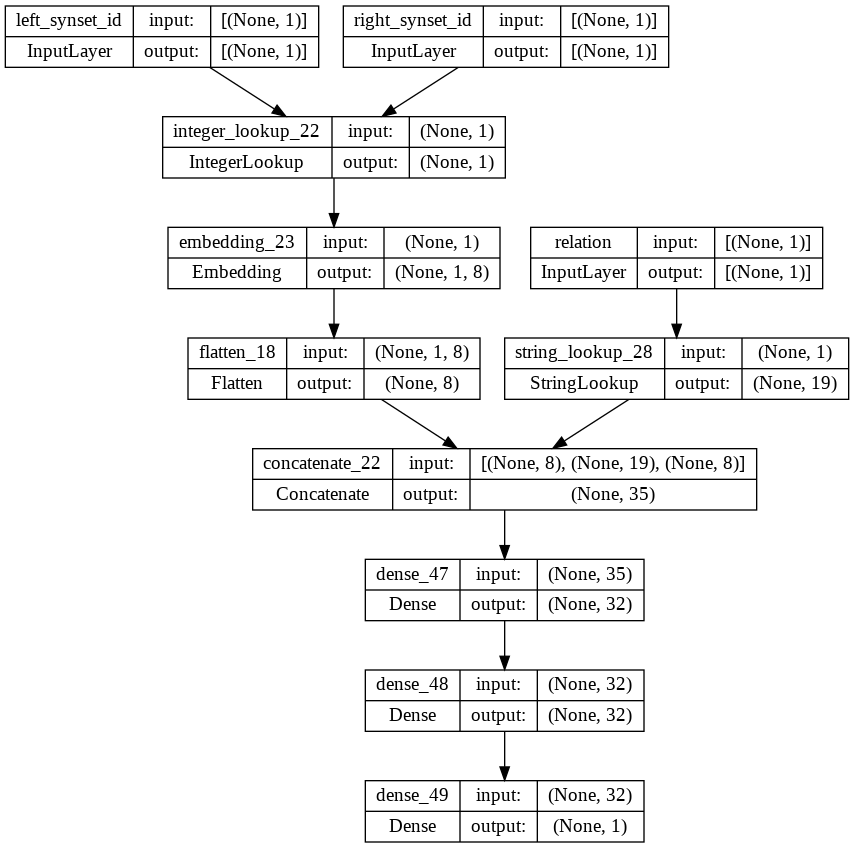

In [346]:
plot_model(model, show_shapes=True)

In [347]:
def to_X_dict(X: pd.DataFrame) -> pd.DataFrame:
  return {
    'left_synset_id': X.left_synset_id,
    'relation': X.relation,
    'right_synset_id': X.right_synset_id,
  }

In [348]:
BATCH_SIZE = 4096

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True,
)

history = model.fit(
  x=to_X_dict(X_train),
  y=y_train,
  batch_size=BATCH_SIZE,
  validation_data=(
      to_X_dict(X_valid),
      y_valid,
  ),
  epochs=30,
  callbacks=[callback],
)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/30
173/173 [==============================] - 32s 183ms/step - loss: 0.4389 - accuracy: 0.8130 - val_loss: 0.2980 - val_accuracy: 0.8636
Epoch 2/30
173/173 [==============================] - 32s 186ms/step - loss: 0.2587 - accuracy: 0.8872 - val_loss: 0.2613 - val_accuracy: 0.8829
Epoch 3/30
173/173 [==============================] - 33s 189ms/step - loss: 0.2196 - accuracy: 0.9072 - val_loss: 0.2427 - val_accuracy: 0.8933
Epoch 4/30
173/173 [==============================] - 32s 186ms/step - loss: 0.1941 - accuracy: 0.9195 - val_loss: 0.2300 - val_accuracy: 0.9009
Epoch 5/30
173/173 [==============================] - 32s 183ms/step - loss: 0.1645 - accuracy: 0.9337 - val_loss: 0.2174 - val_accuracy: 0.9067
Epoch 6/30
173/173 [==============================] - 32s 188ms/step - loss: 0.1297 - accuracy: 0.9500 - val_loss: 0.2032 - val_accuracy: 0.9165
Epoch 7/30
173/173 [==============================] - 32s 182ms/step - loss: 0.0971 - accuracy: 0.9648 - val_loss: 0.1964 - val_ac

In [349]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

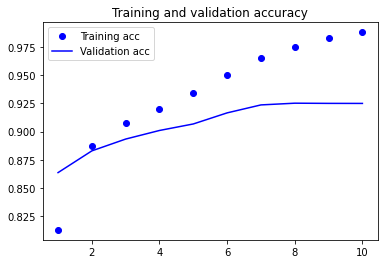

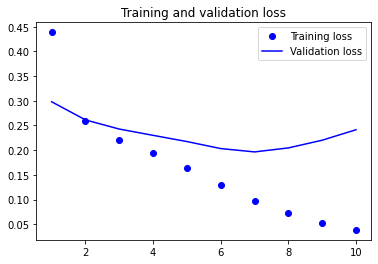

In [350]:
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [351]:
y_pred = model.predict(to_X_dict(X_test), batch_size=128)

196/196 [==============================] - 13s 67ms/step


In [352]:
print(classification_report(y_test.values, y_pred.flatten() > 0.5, target_names=['Invalid', 'Valid']))

              precision    recall  f1-score   support

     Invalid       0.95      0.95      0.95     20000
       Valid       0.81      0.81      0.81      5000

    accuracy                           0.92     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.92      0.92      0.92     25000

